1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

In [1]:
import numpy as np
from scipy import linalg as la
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy import optimize
import pandas as pd
from scipy import integrate
from scipy import constants

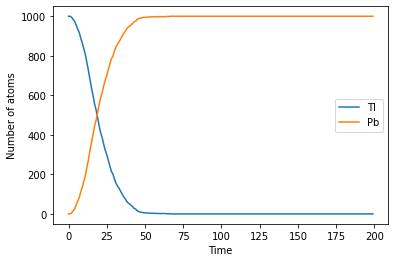

In [2]:
t_decay = 3.052*60
time = np.arange(1,200)
num_tl = [1000]
num_pb = [0]

def prob(t, t_decay):
    return 1-2**(-t/t_decay)    

    
for t in time:
    ev = np.random.random(num_tl[t-1])
    num_decay = ev.copy()
    
    mask = ev < (prob(t,t_decay))
    
    num_decay[mask] = 1
    num_decay[num_decay != 1] = 0
    
    tot_decay = int(np.sum(num_decay))
    
    num_tl.append(num_tl[t-1]-tot_decay)
    num_pb.append(num_pb[t-1]+tot_decay)
    
timeplot = np.arange(0,200)
plt.plot(timeplot,num_tl,label='Tl')
plt.plot(timeplot,num_pb,label='Pb')
plt.xlabel('Time')
plt.ylabel('Number of atoms')
plt.legend()

Text(0, 0.5, 'Number of decays')

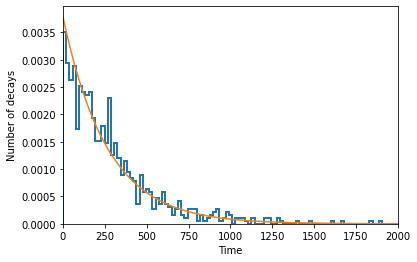

In [3]:
def inv_prob (x, t_decay):
    return -np.log(1-x)*t_decay/np.log(2)

def d_prob (t, t_decay):
    return 2**(-t/t_decay)*np.log(2)/t_decay

ran = np.random.random(1000)
inv_ran = inv_prob(ran, t_decay)
time_p = np.linspace(0,2000,1000)

plt.hist(inv_ran,histtype='step', bins=100, density=True, linewidth=2)
plt.plot(time_p,d_prob(time_p,t_decay))
plt.xlim(0,2000)
plt.xlabel('Time')
plt.ylabel('Number of decays')

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

Fraction of bounced particles:  0.003  =  6  over  2000


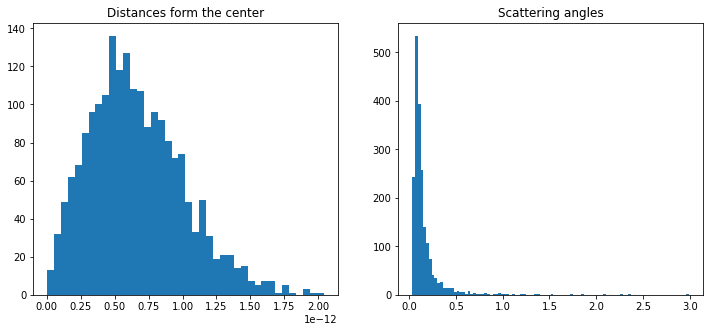

In [4]:
a0 = constants.physical_constants["Bohr radius"][0]
e = constants.physical_constants["atomic unit of charge"][0]
e0 = constants.epsilon_0
E=7.7*1.6021e-19*(10**6)
Z=89

sigma = a0/100
x = np.random.normal(0,sigma,2000)
y = np.random.normal(0,sigma,2000)
b = np.sqrt(x**2+y**2)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(b,bins=40)
plt.title('Distances form the center')

def scatt_angle (b,Z,e,e0,E):
    return 2*np.arctan((Z*e**2)/(2*np.pi*e0*E*b))

plt.subplot(122)
plt.hist(scatt_angle(b,Z,e,e0,E),bins=100)
plt.title('Scattering angles')

print('Fraction of bounced particles: ',int(scatt_angle(b,Z,e,e0,E)[scatt_angle(b,Z,e,e0,E)>(np.pi/2)].size)/2000, ' = ', int(scatt_angle(b,Z,e,e0,E)[scatt_angle(b,Z,e,e0,E)>(np.pi/2)].size), ' over ', 2000)


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [5]:
def f(x):
    return np.sin(1/(x*(2-x)))**2

# Monte Carlo integration
N=100000
count=0
for i in range(N):
    x=2*np.random.random()
    y=np.random.random()
    if y<f(x): count+=1
I=2*count/N
print("Hit and miss :",I)

#Mean integration
x = 2*np.random.random(N)
Im=((2-0)/N)*np.sum(f(x))
print("Mean method :", Im)

#Correct integral
corr_int=integrate.quad(f,0,2)
print('\n', 'Precise integral: ', corr_int[0],'error: ', corr_int[1], '\n')

Hit and miss : 1.45282
Mean method : 1.45270981077118

 Precise integral:  1.4516877509810684 error:  0.002712378152591422 



<ipython-input-5-6a26e4cd88ae>:20: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  corr_int=integrate.quad(f,0,2)


In [6]:
print('Differences:')
i=0
dmhm,dmvm=[],[]

print('delta hit=',corr_int[0]-I,'\n',' delta mean=',corr_int[0]-Im)
dmhm.append(corr_int[0]-I)
dmvm.append(corr_int[0]-Im)


Differences:
delta hit= -0.0011322490189316081 
  delta mean= -0.0010220597901116069


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [7]:
def f(x, y):
    return np.sqrt((x-1)**2 + (y-1)**2) <= 1

def MonteCarloArea(numberOfPoints):
    squareSide = 2
    Cx = 1
    Cy = 1
 
    pointsInside = 0
    for i in range(numberOfPoints):
        x = np.random.random()*squareSide
        y = np.random.random()*squareSide
 
        if (f(x, y)):
            pointsInside = pointsInside + 1
 
    return pointsInside / numberOfPoints * squareSide**2

print(MonteCarloArea(10000))

3.1412


In [16]:
dim=10
ns=1000000
x=(np.random.random((dim,ns))*2)-1

def f(x):
    return np.sum(x**2,axis=0)

dist = f(x)
           
counts=0
for d in dist:
    if d<1:
        counts+=1
        
print('Computational area:', (counts/ns)*(2**dim))
print('Algebric area: ', 1/120*np.pi**5)
                   


Computational area: 2.5344
Algebric area:  2.550164039877345


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

For N= 1000000 Integral= 0.7597709952538886


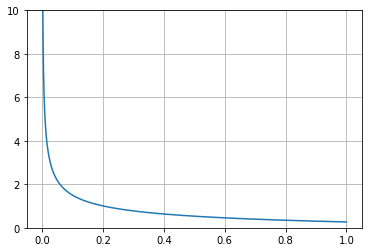

In [31]:
def f (x):
    return pow(x,-(1/2))/(np.exp(x)+1)

def w(x):
    return 1/(pow(x,1/2))

x=np.linspace(1e-10,1,100000)
plt.plot(x,f(x))
plt.ylim(0,10)
plt.grid(True)
#plt.yticks(np.linspace(1,10,10))

N=1000000


x=np.linspace(1e-30,1,N)
rapp=(f(x))/(w(x))

I=(1./N)*(np.sum(f(x)/w(x)))*w_int[0]
print('For N=',N, 'Integral=',I)

